# Task 1: Interest Point Detection, Feature Matching, and Contour Detection

## 1. Interest Point Detection using SIFT

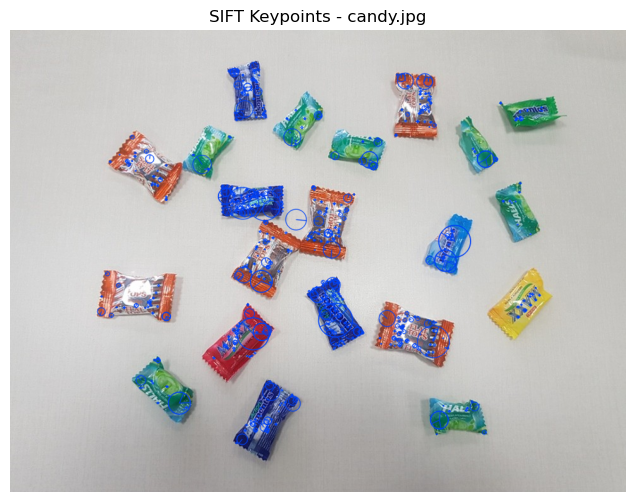

Number of keypoints detected in candy.jpg: 1000


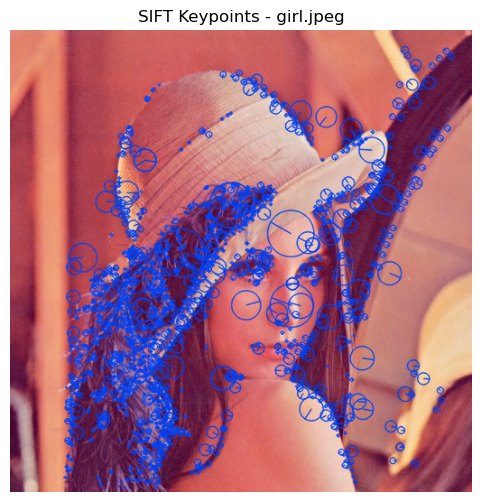

Number of keypoints detected in girl.jpeg: 2000


In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define images and their individual SIFT parameters
images_with_params = [
    {
        "filename": "candy.jpg",
        "nfeatures": 1000,
        "contrastThreshold": 0.01,
        "edgeThreshold": 20,
        "sigma": 0.5
    },
    {
        "filename": "girl.jpeg",
        "nfeatures": 2000,
        "contrastThreshold": 0.01,
        "edgeThreshold": 20,
        "sigma": 0.5
    }
]

# Loop through each image with its corresponding parameters
for entry in images_with_params:
    image_file = entry["filename"]
    image = cv2.imread(image_file)

    if image is None:
        print(f"Error loading {image_file}. Skipping.")
        continue

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Create a SIFT detector with image-specific parameters
    sift = cv2.SIFT_create(
        nfeatures=entry["nfeatures"],
        contrastThreshold=entry["contrastThreshold"],
        edgeThreshold=entry["edgeThreshold"],
        sigma=entry["sigma"]
    )

    keypoints, descriptors = sift.detectAndCompute(gray, None)

    image_with_keypoints = cv2.drawKeypoints(
        image, keypoints, None,
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
        color=(0, 65, 244)
    )

    plt.figure(figsize=(8, 6))
    plt.imshow(image_with_keypoints)
    plt.title(f'SIFT Keypoints - {image_file}')
    plt.axis('off')
    plt.show()

    print(f"Number of keypoints detected in {image_file}: {len(keypoints)}")

## 2. Feature Matching using ORB and BFMatcher

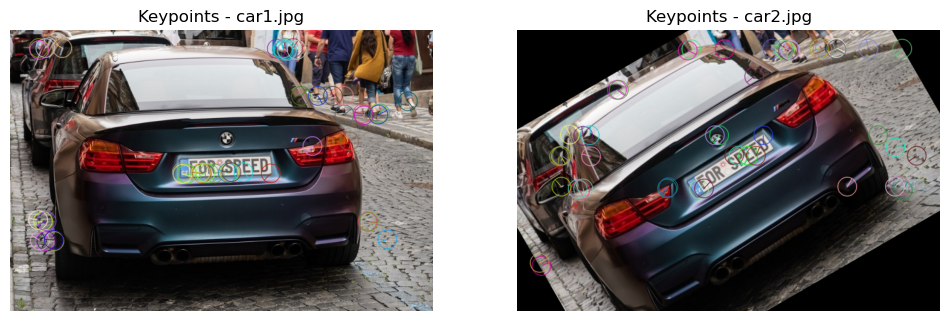

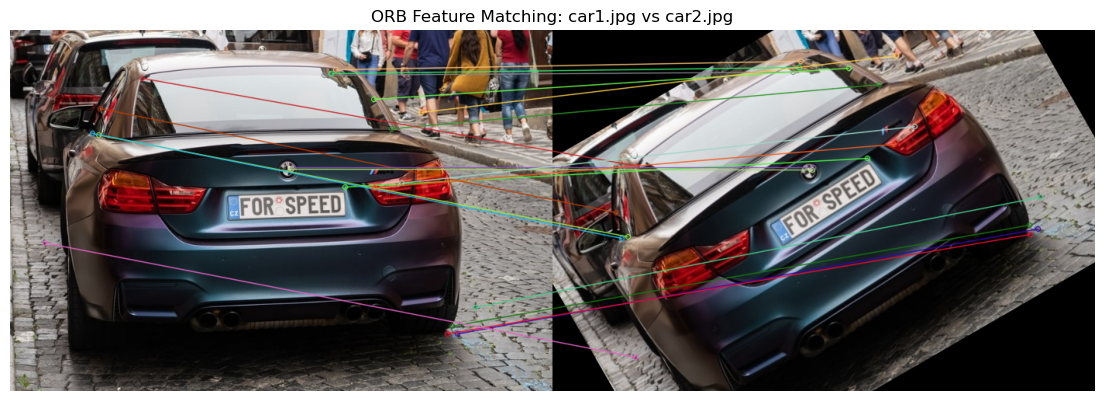

Number of matches between car1.jpg and car2.jpg: 641


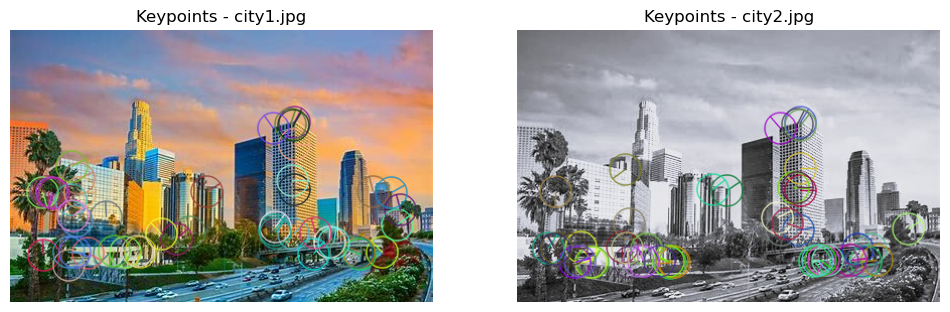

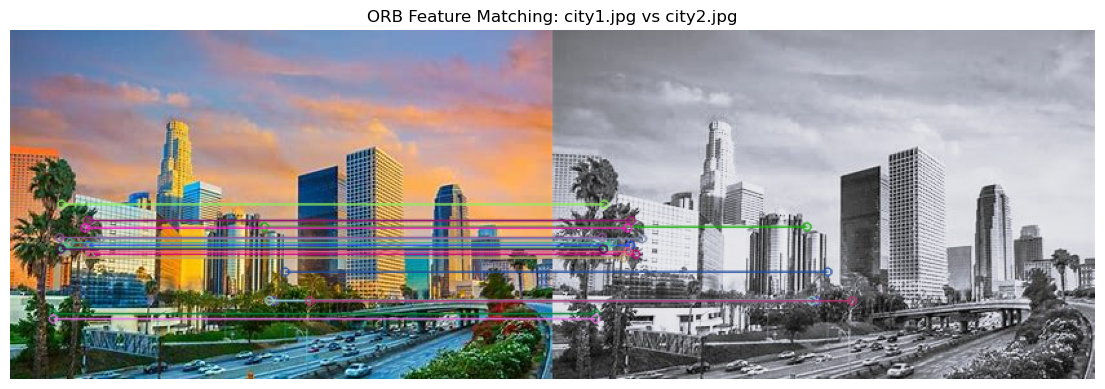

Number of matches between city1.jpg and city2.jpg: 967


In [16]:
import cv2
import matplotlib.pyplot as plt

# Define image pairs with their individual ORB parameters
image_pairs_with_params = [
    {
        'img1': 'car1.jpg',
        'img2': 'car2.jpg',
        'nfeatures': 1500,
        'scaleFactor': 2,
        'nlevels': 8
    },

    {
        'img1': 'city1.jpg',
        'img2': 'city2.jpg',
        'nfeatures': 2200,
        'scaleFactor': 1.2,
        'nlevels': 6
    }
]

for pair in image_pairs_with_params:
    img1_file = pair['img1']
    img2_file = pair['img2']

    # Load the images
    img1 = cv2.imread(img1_file)
    img2 = cv2.imread(img2_file)

    if img1 is None or img2 is None:
        print(f"Error loading images: {img1_file}, {img2_file}. Skipping.")
        continue

    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    # Initialize ORB with custom parameters
    orb = cv2.ORB_create(
        nfeatures=pair['nfeatures'],
        scaleFactor=pair['scaleFactor'],
        nlevels=pair['nlevels']
    )

    # Detect keypoints and descriptors
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    # Draw first 50 keypoints
    img1_kp = cv2.drawKeypoints(img1, kp1[:50], None, flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
    img2_kp = cv2.drawKeypoints(img2, kp2[:50], None, flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img1_kp)
    plt.title(f'Keypoints - {img1_file}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img2_kp)
    plt.title(f'Keypoints - {img2_file}')
    plt.axis('off')
    plt.show()

    # Use Brute-Force Matcher with Hamming distance
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    # Draw top matches
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:20], None,
                                  flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.figure(figsize=(14, 6))
    plt.imshow(img_matches)
    plt.title(f'ORB Feature Matching: {img1_file} vs {img2_file}')
    plt.axis('off')
    plt.show()

    print(f"Number of matches between {img1_file} and {img2_file}: {len(matches)}")

## 3. Contour Detection with Custom Seeds using Watershed Algorithm

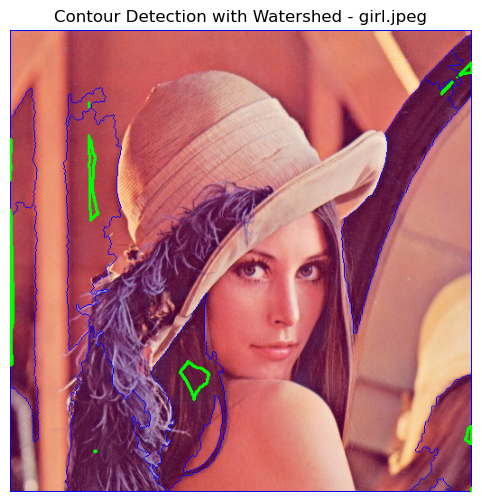

Number of contours detected in girl.jpeg: 11


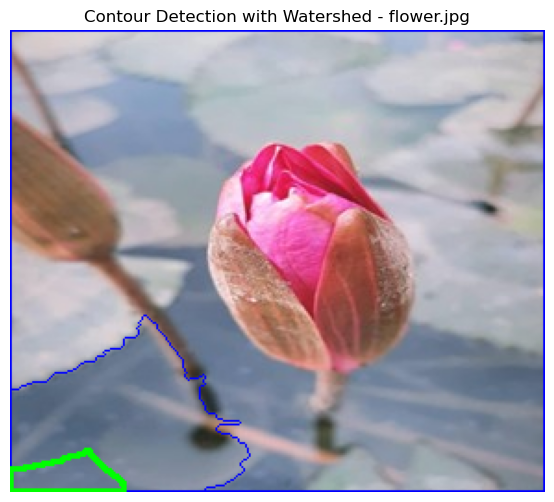

Number of contours detected in flower.jpg: 1


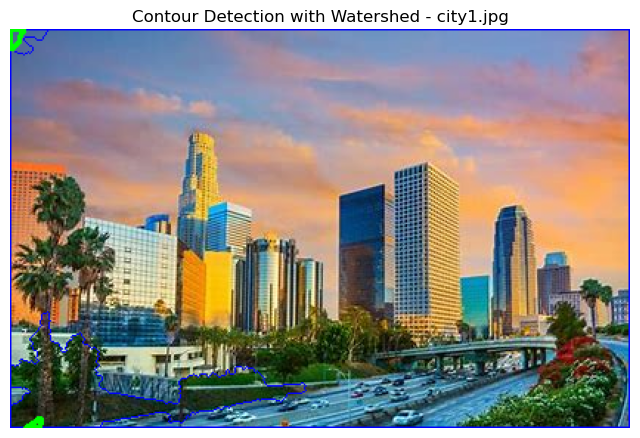

Number of contours detected in city1.jpg: 2


In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# List of image filenames
image_files = ['girl.jpeg', 'flower.jpg', 'city1.jpg']  # Replace with your image filenames

for img_file in image_files:
    # Load the image
    img = cv2.imread(img_file)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply thresholding to create a binary image
    _, thresh = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Remove noise with morphological opening
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Identify sure background (dilate the opening)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    
    # Identify sure foreground (distance transform + thresholding)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    
    # Unknown region (difference between sure background and foreground)
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    # Create markers for watershed
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1  # Increment to distinguish from background (0)
    markers[unknown == 255] = 0  # Mark unknown regions as 0
    
    # Apply watershed algorithm
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert to BGR for color marking
    markers = cv2.watershed(img_bgr, markers)
    img_bgr[markers == -1] = [0, 0, 255]  # Mark boundaries in red
    
    # Find and draw contours
    contours, _ = cv2.findContours(sure_fg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(img_bgr, contours, -1, (0, 255, 0), 2)  # Green contours
    
    # Display the result
    plt.figure(figsize=(8, 6))
    plt.imshow(img_bgr)
    plt.title(f'Contour Detection with Watershed - {img_file}')
    plt.axis('off')
    plt.show()
    
    print(f"Number of contours detected in {img_file}: {len(contours)}")
